## 1. 关于数据集

### 介绍

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.  

### 数据字段

  
Data Fields  
datetime - hourly date + timestamp    
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
holiday - whether the day is considered a holiday  
workingday - whether the day is neither a weekend nor holiday  
weather -   
          1. Clear, Few clouds, Partly cloudy, Partly cloudy
          2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist   
          3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds   
          4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
temp - temperature in Celsius  
atemp - "feels like" temperature in Celsius  
humidity - relative humidity  
windspeed - wind speed  
casual - number of non-registered user rentals initiated  
registered - number of registered user rentals initiated  
count - number of total rentals  

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import calendar
from datetime import datetime

import seaborn as sn
from scipy import stats


ImportError: No module named matplotlib

### 加载数据

In [266]:
data_path = 'train.csv'

rides = pd.read_csv(data_path)

## 2. 探索数据

### 数据集的大小

In [267]:
rides.shape

(10886, 12)

### 前几行的样本

In [268]:
rides.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


### 变量的数据类型

In [269]:
rides.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## 3. 特征工程

### 此处做如下工作：
     1. 从datetime特征中提取出月、日、小时、周几、这几个特征；
     2. 将season、holiday、workingday、weather这几个特征的值类型变成'category'
     3. 去掉datetime

In [270]:
rides['month'] = rides.datetime.apply(lambda s : calendar.month_name[datetime.strptime(s.split()[0], "%Y-%m-%d").month])
rides['weekday'] = rides.datetime.apply(lambda s : calendar.day_name[datetime.strptime(s.split()[0], "%Y-%m-%d").weekday()])
rides['hour'] = rides.datetime.apply(lambda s : s.split()[1].split(':')[0])
rides["season"] = rides.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
rides["weather"] = rides.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

### 转换成Category类型

In [272]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    rides[var] = rides[var].astype("category")

In [273]:
rides.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,weekday,hour
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,January,Saturday,00
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,January,Saturday,01


### 去掉datetime

In [274]:
rides = rides.drop('datetime', axis=1)

### 检查查看下各数据类型的特征数量

In [275]:
dataTypeDf = pd.DataFrame(rides.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})

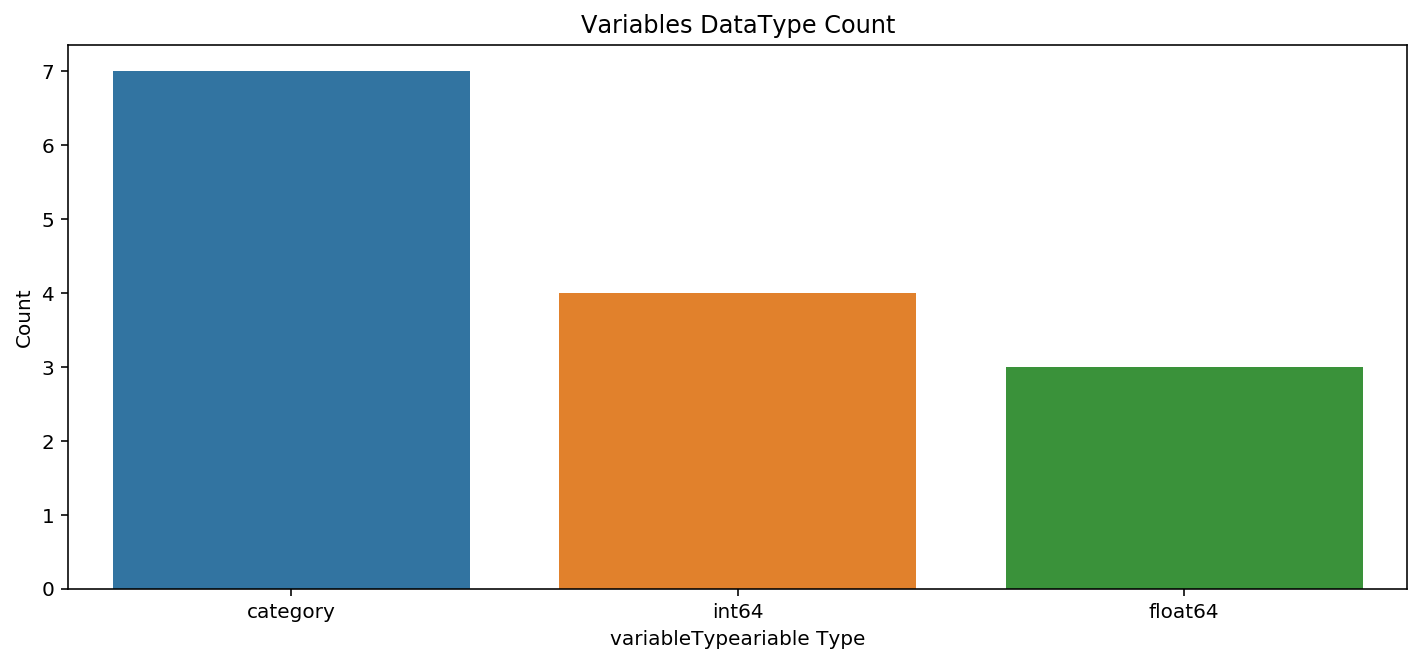

In [276]:
dataTypeDf = pd.DataFrame(rides.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

## 4. 缺失值分析

### 查看缺失值情况

In [277]:
rides.isnull().any()

season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
month         False
weekday       False
hour          False
dtype: bool

## 5.异常值分析

从下面的1图可以看出，count的一些值向右倾斜，

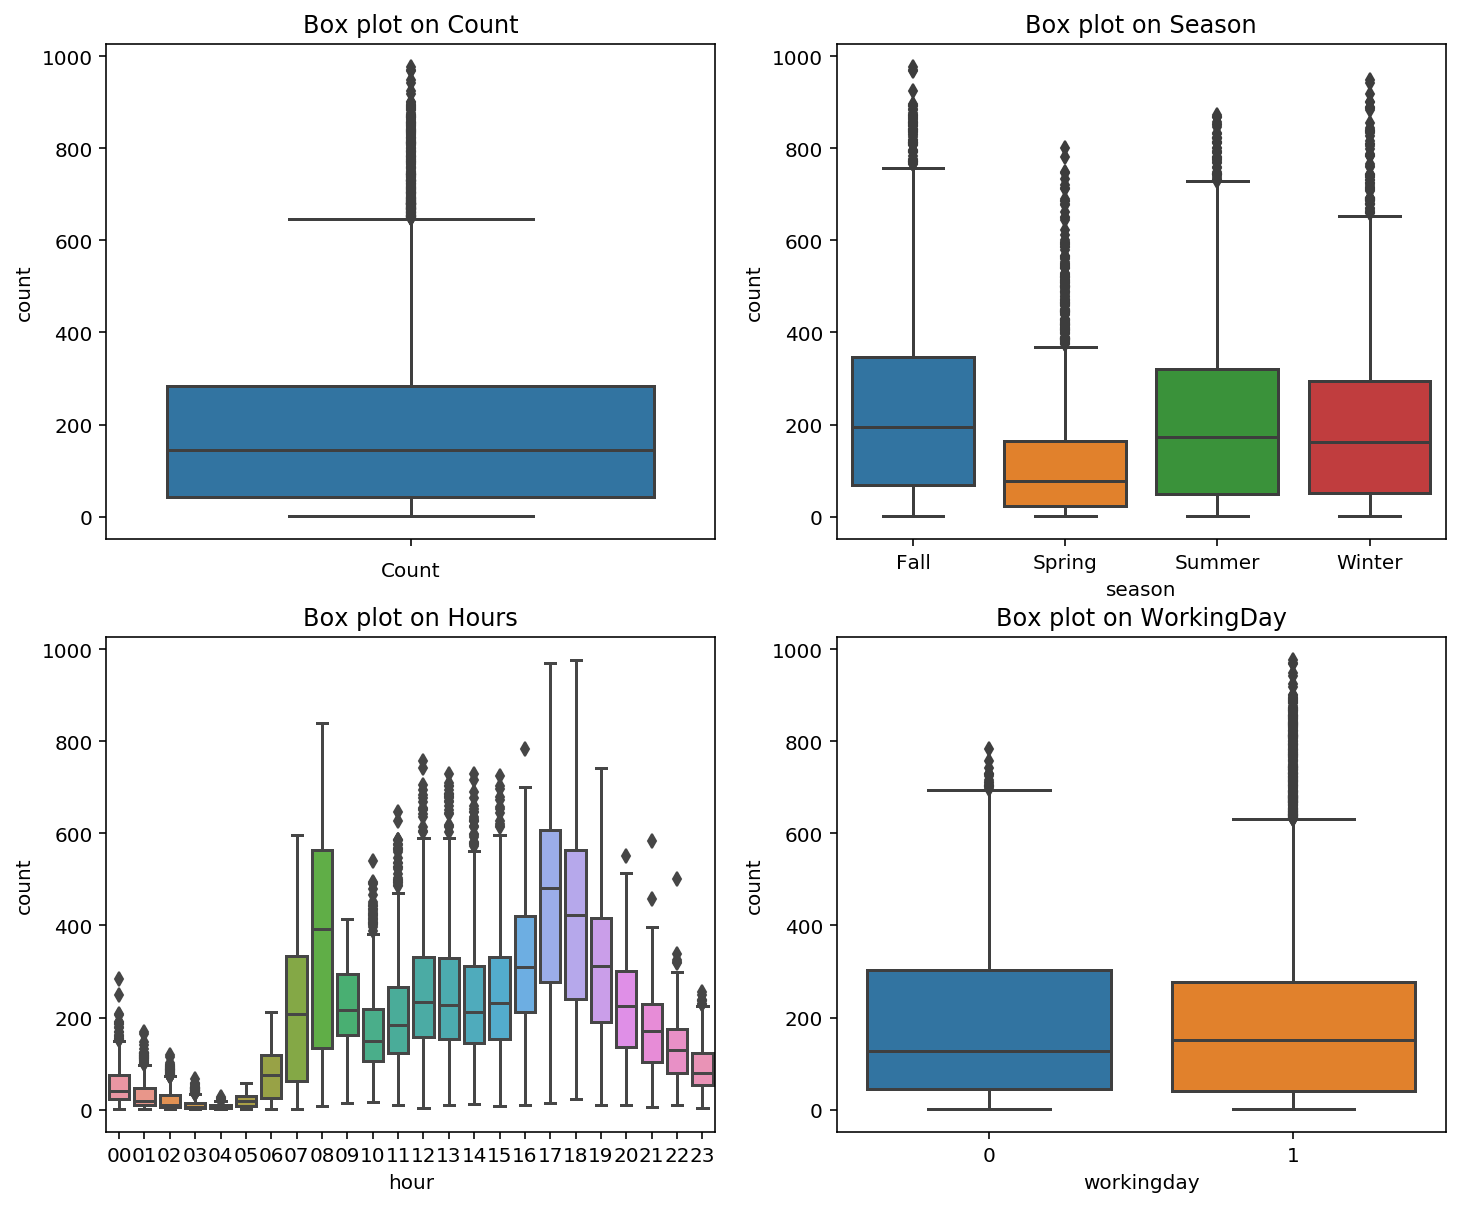

In [287]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(12, 10)

sn.boxplot(data=rides, y='count', ax=axes[0][0])
sn.boxplot(data=rides, y='count', x='season', ax=axes[0][1])
sn.boxplot(data=rides, y='count', x='hour', ax=axes[1][0])
sn.boxplot(data=rides, y='count', x='workingday', ax=axes[1][1])

axes[0][0].set(xlabel="Count", title="Box plot on Count")
axes[0][1].set(title="Box plot on Season")
axes[1][0].set(title="Box plot on Hours")
axes[1][1].set(title="Box plot on WorkingDay")

### 清除异常值

In [316]:
data_without_outlier = rides[np.abs(rides['count'] - rides['count'].mean()) <= 3*rides['count'].std()]

## 相关性分析

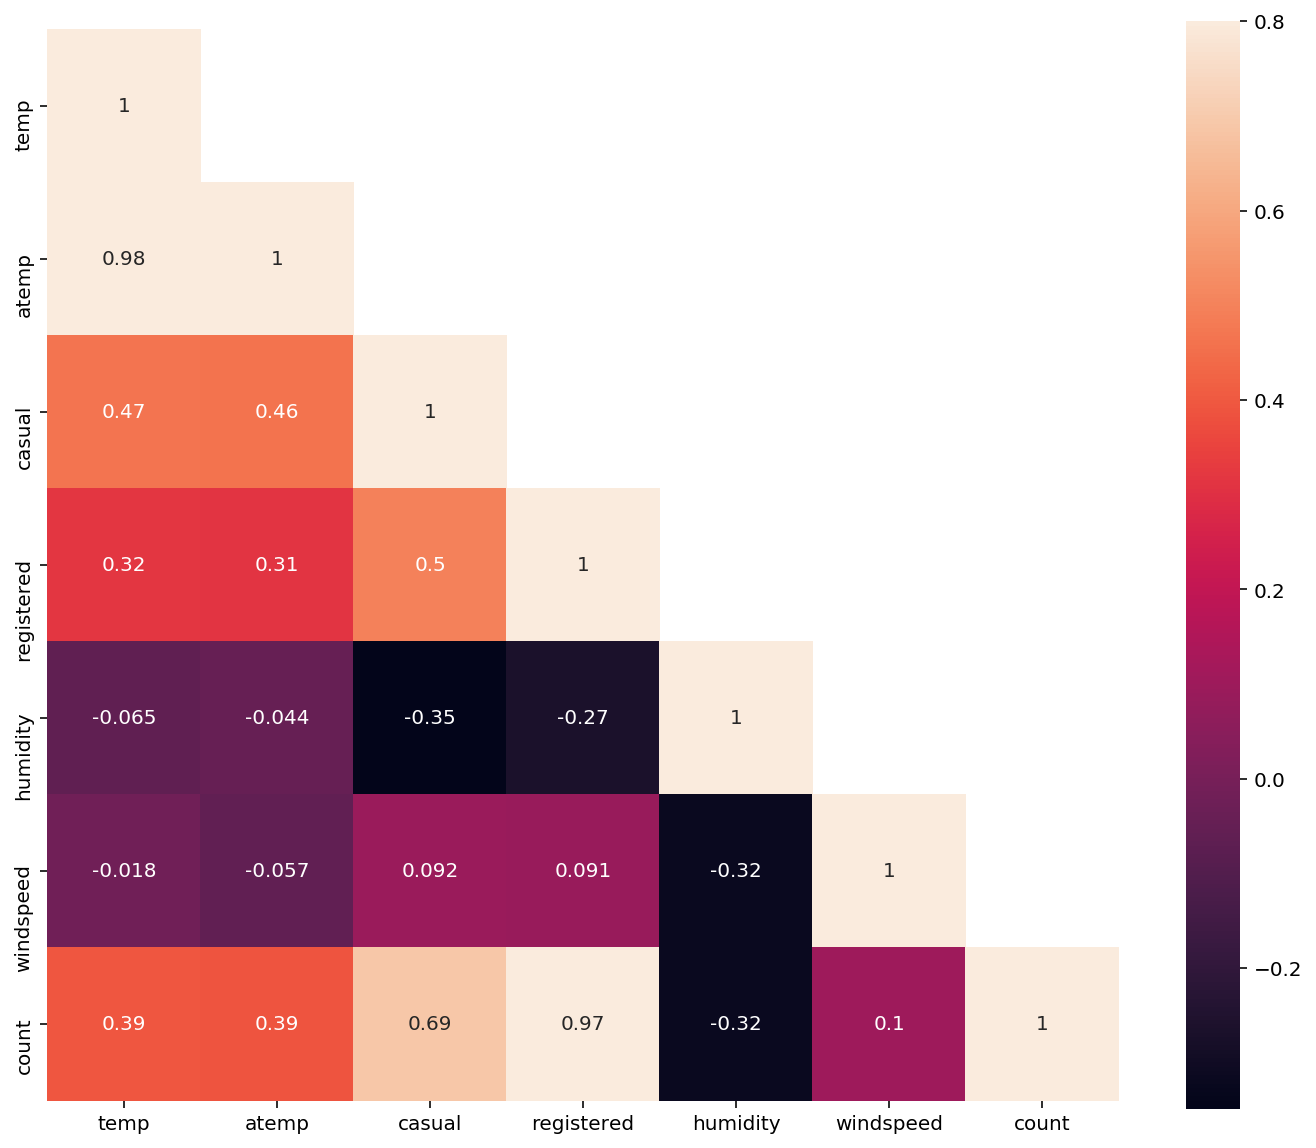

In [305]:
corrMat = rides[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()

fig, ax = plt.subplots()
fig.set_size_inches(12,10)

mask = np.array(corrMat)
mask[np.tril_indices_from(mask)] = False

sn.heatmap(corrMat, ax =ax, vmax=.8, square=True, annot=True, mask = mask)


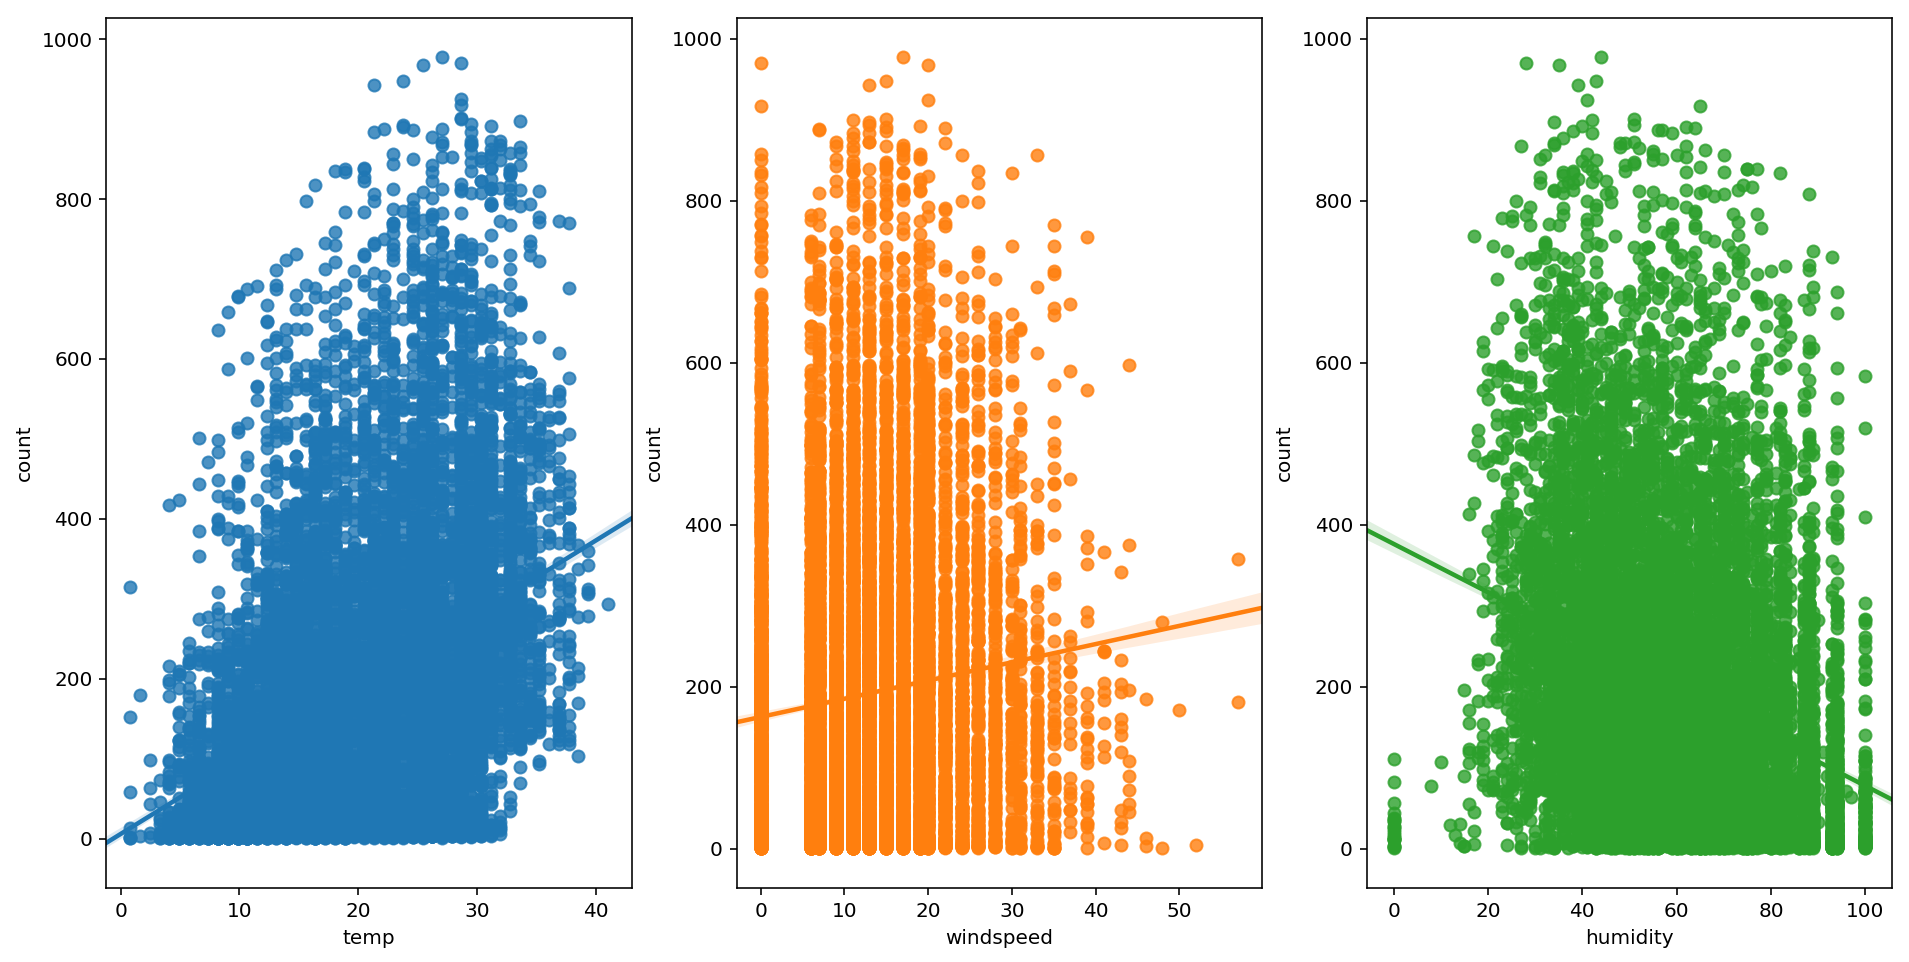

In [312]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(16, 8)

sn.regplot(data=rides, y='count', x='temp', ax=ax1)
sn.regplot(data=rides, y='count', x='windspeed', ax=ax2)
sn.regplot(data=rides, y='count', x='humidity', ax=ax3)

## 查看数据分布

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.5971457 ,
          6.59850903,  6.5998705 ])),
 (1.3486990121229776, 4.5624238680878078, 0.95811767809096138))

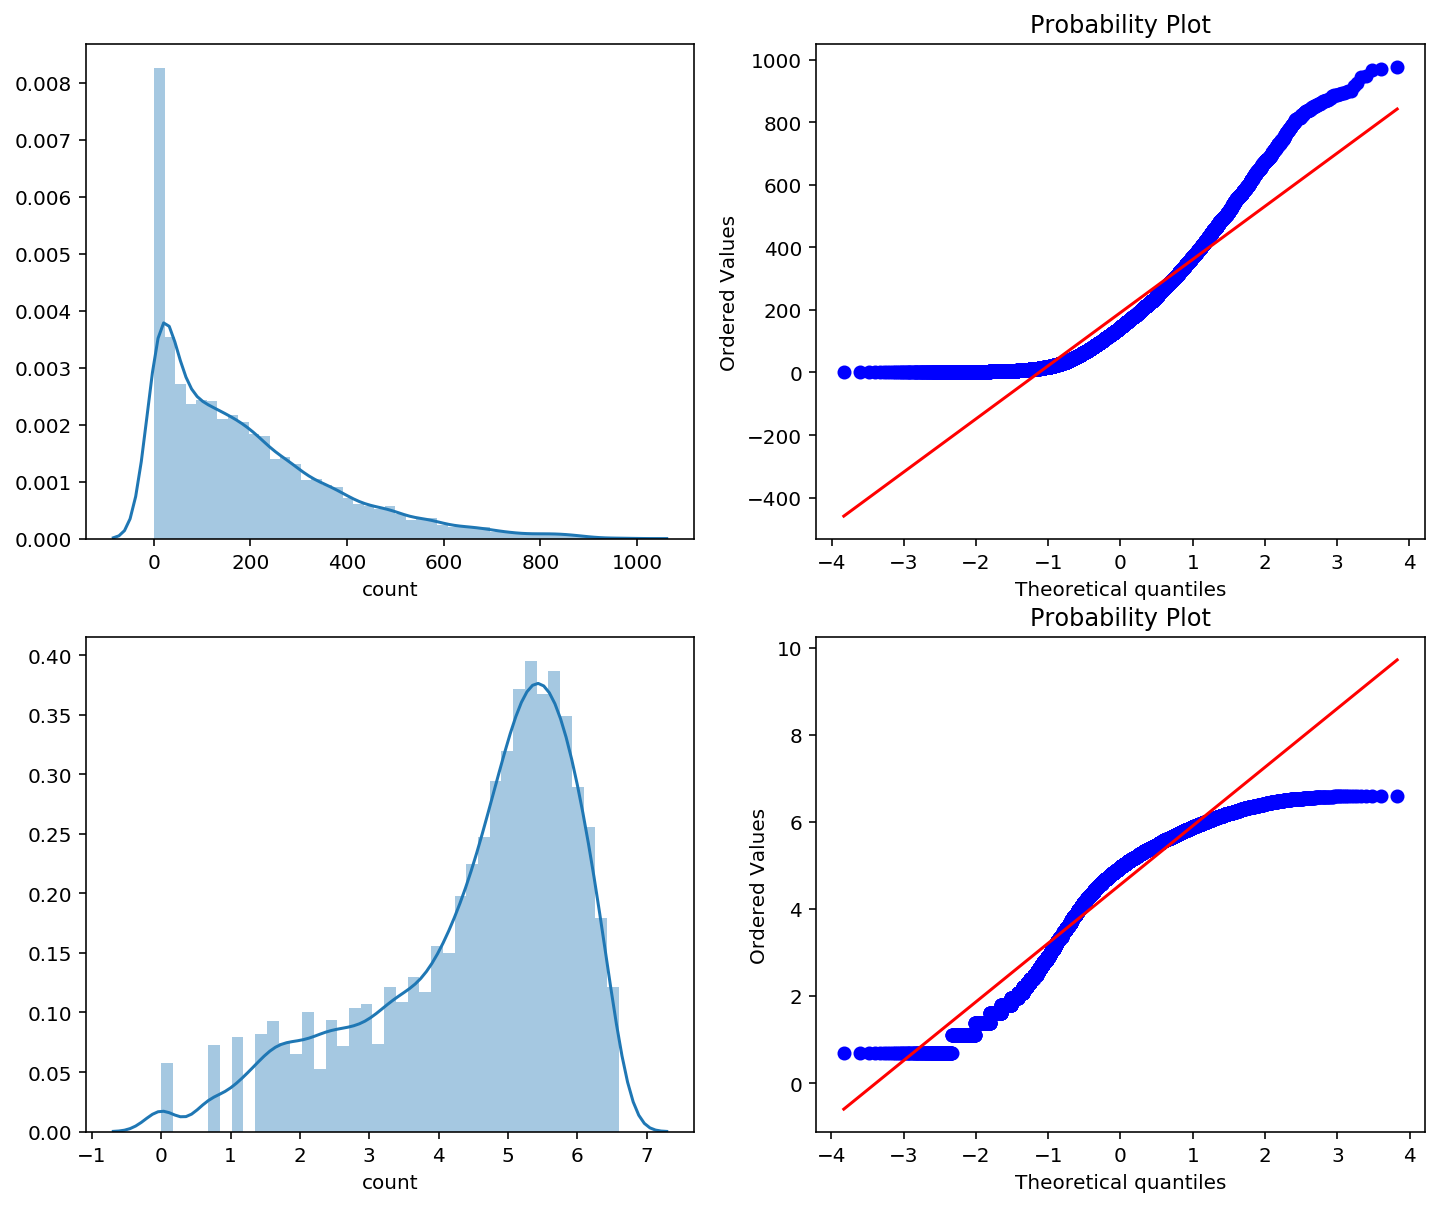

In [317]:

fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(rides["count"],ax=axes[0][0])
stats.probplot(rides["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(data_without_outlier["count"]),ax=axes[1][0])
stats.probplot(np.log1p(data_without_outlier["count"]), dist='norm', fit=True, plot=axes[1][1])

## 查看count和Season、month、weekday、hour的关系

 None]

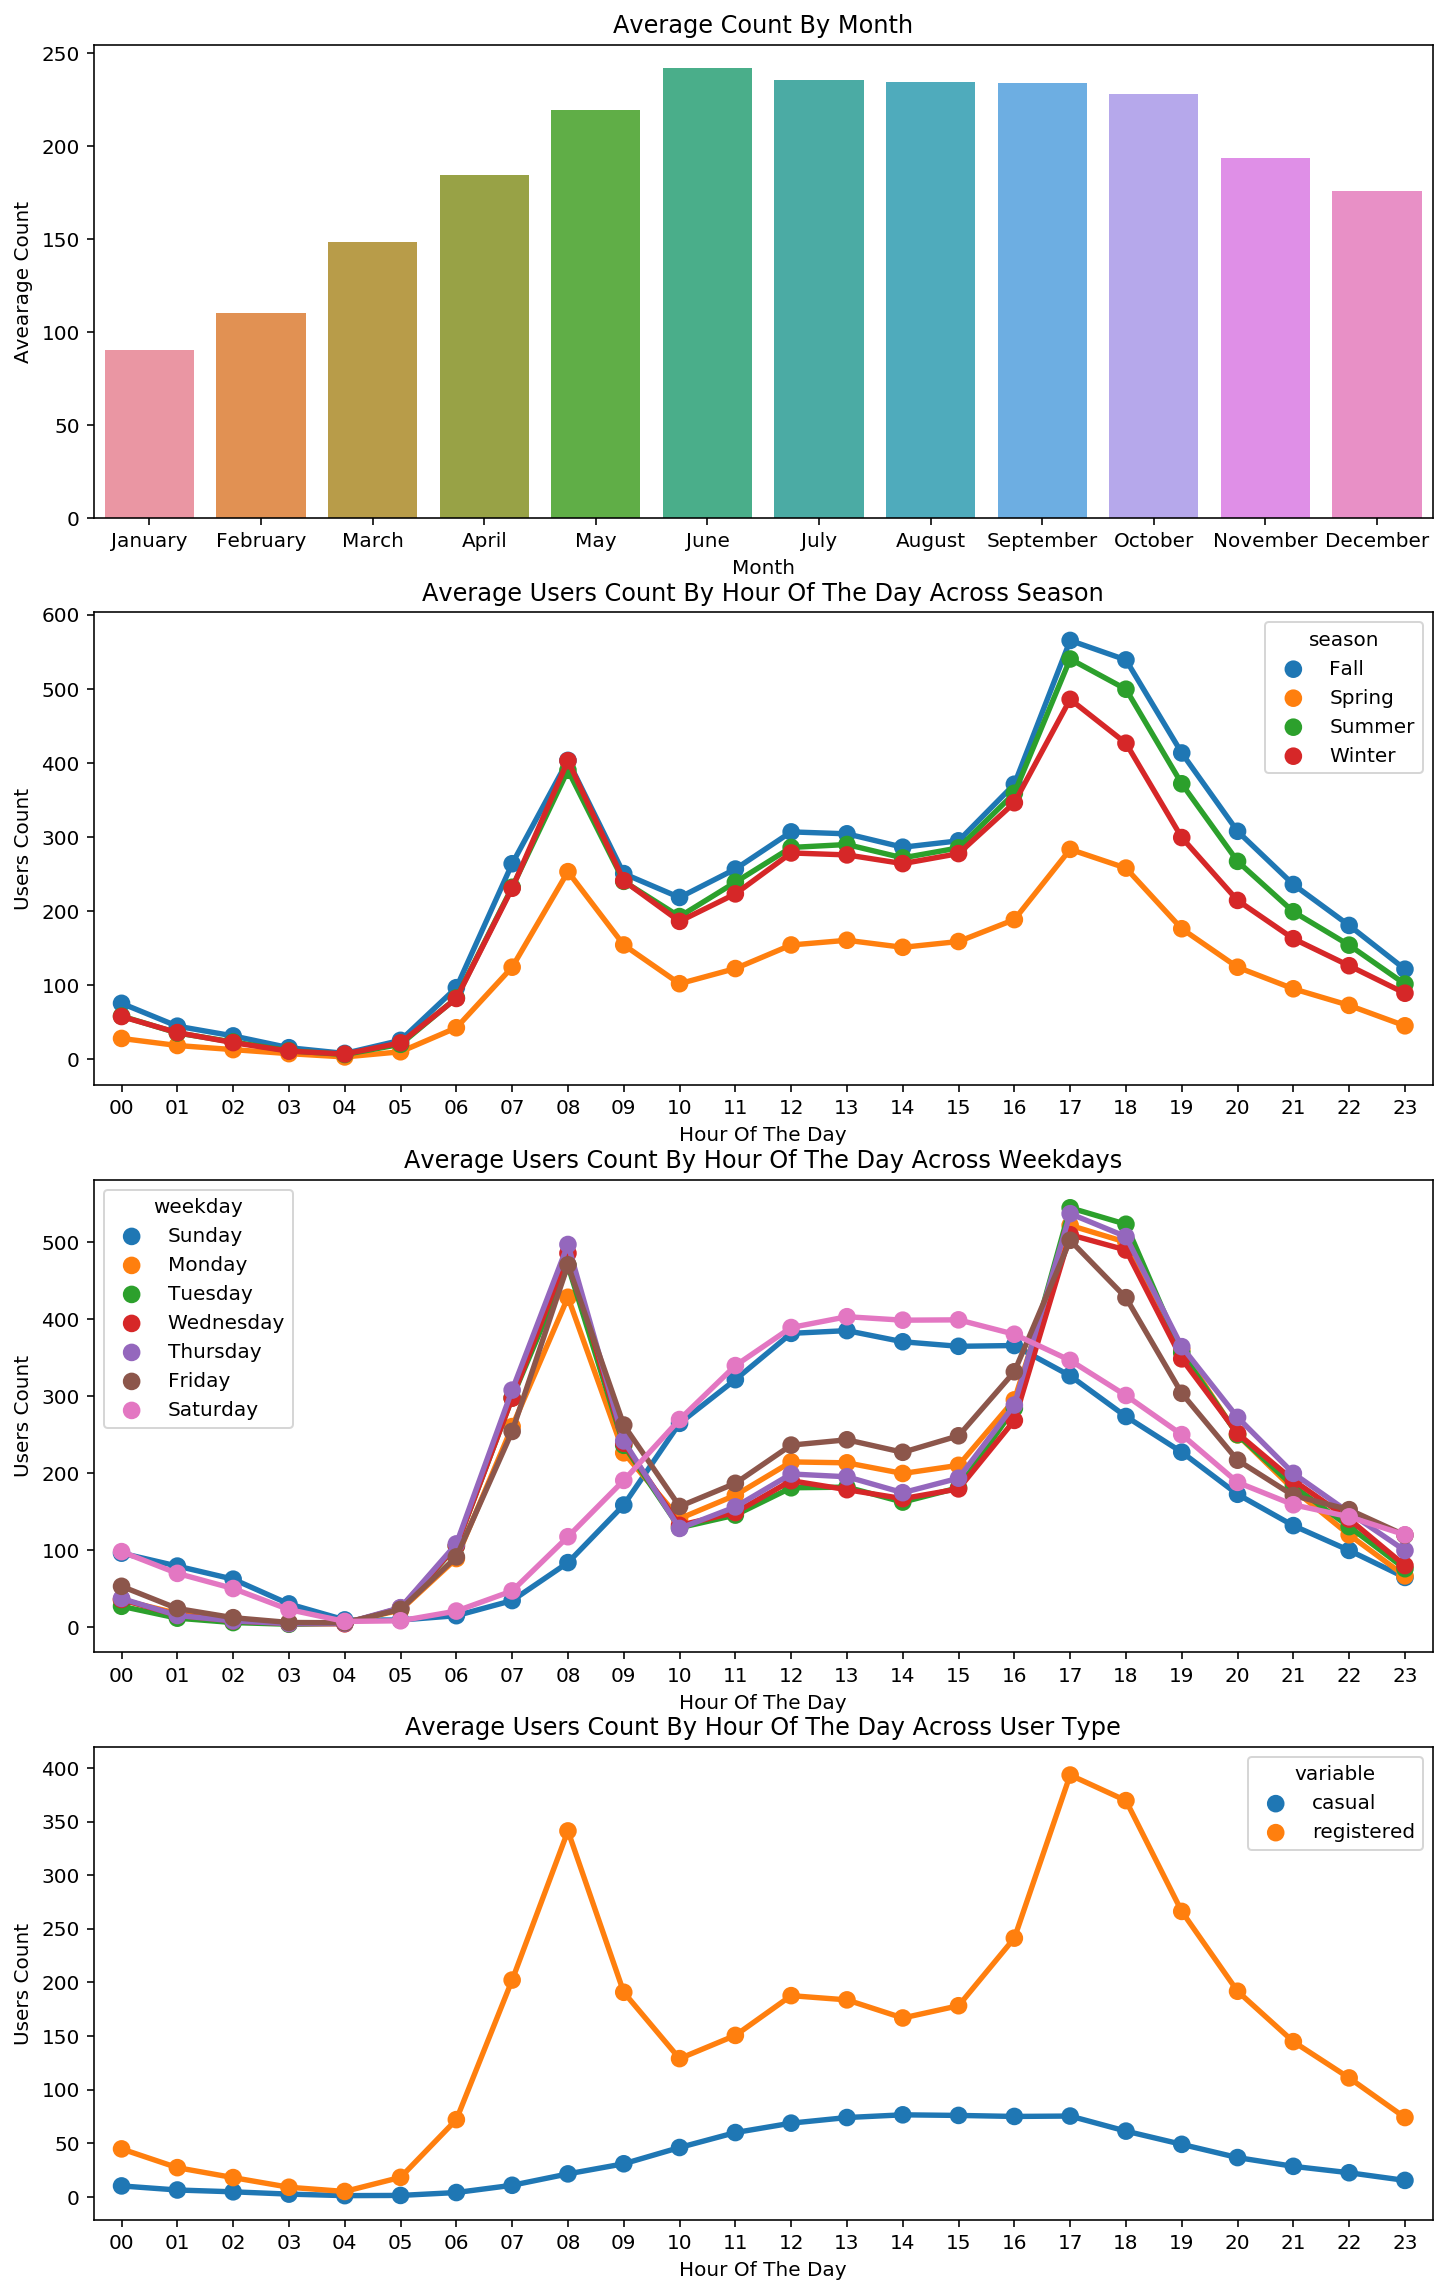

In [319]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(rides.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(rides.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(rides.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(rides[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

## 准备数据

### 读取数据

In [495]:
dataTrain = pd.read_csv("train.csv")
dataTest = pd.read_csv("test.csv")

### 组合训练和测试数据

In [496]:
data = dataTrain.append(dataTest)

In [497]:
data.reset_index(inplace=True)  #reset之后，之前的索引变成‘index’
data = data.drop('index', axis=1)

### 特征工程

In [498]:
data['date'] = data.datetime.apply(lambda x : x.split()[0])
data['year'] = data.date.apply(lambda x : x.split('-')[0]).astype('int')
data['month'] = data.date.apply(lambda x : x.split('-')[1]).astype('int')
data['weekday'] = data.date.apply(lambda x : datetime.strptime(x, "%Y-%m-%d").weekday())
data['hour'] = data.datetime.apply(lambda x : x.split()[1].split(':')[0]).astype('int')

### 转换成Category类型

In [499]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered", 'windspeed', 'atemp']

In [500]:
for each in categoricalFeatureNames:
    data[each] = data[each].astype('category')

### 变成哑变量

In [452]:
data = pd.get_dummies(data, columns=categoricalFeatureNames)

### 切分训练和测试

In [501]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])

datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

### 丢弃不需要的特征

In [502]:
dataTrain = dataTrain.drop(dropFeatures, axis=1)
dataTest = dataTest.drop(dropFeatures, axis=1)

### RMSLE的计算

In [503]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## 线性模型

In [474]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

('RMSLE Value For Linear Regression: ', 0.97781888295471187)


## 随机森林

In [482]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

('RMSLE Value For Random Forest: ', 0.1032159642880946)


## GBDT

In [504]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

('RMSLE Value For Gradient Boost: ', 0.20531187866108519)


## 预测

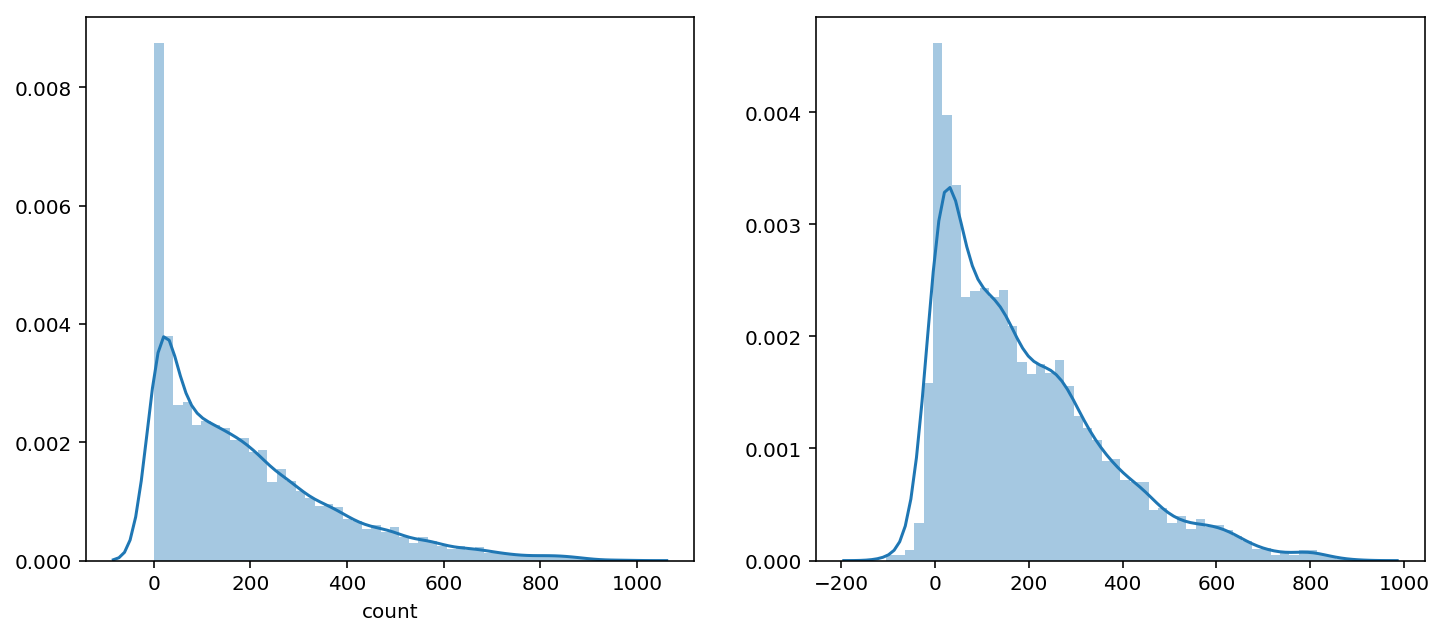

In [480]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot((predsTest),ax=ax2,bins=50)

## 提交

In [481]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in (predsTest)]
    })
submission.to_csv('bike_predictions.csv', index=False)